In [1]:
import os 

os.chdir('../..')

In [2]:
import warnings 

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
def download_file(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    print(f"File downloaded successfully: {file_path}")

In [5]:
file_links = ["https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet" , "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet"]

In [6]:
DATASET_PATH = "datasets"
os.makedirs(DATASET_PATH, exist_ok=True)

In [7]:
for file_link in file_links:
    file_name = file_link.split('/')[-1]
    download_file(file_link, os.path.join(DATASET_PATH, file_name))

File downloaded successfully: datasets/yellow_tripdata_2022-01.parquet
File downloaded successfully: datasets/yellow_tripdata_2022-02.parquet


In [8]:
# Read the data for January. How many columns are there?

In [9]:
jan_df = pd.read_parquet(os.path.join(DATASET_PATH, "yellow_tripdata_2022-01.parquet"))

In [10]:
display(jan_df.head())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [11]:
display(jan_df.columns , f"{len(jan_df.columns)} columns")

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

'19 columns'

In [12]:
# Question 2:  Standard deviation of the trips duration in Jan 2022 Yellow Taxi Trip data

In [13]:
jan_df["duration"] = jan_df["tpep_dropoff_datetime"] - jan_df["tpep_pickup_datetime"]

In [14]:
jan_df["duration"] = jan_df["duration"].dt.total_seconds()/60

In [15]:
jan_df["duration"].std()

46.44530513776802

In [16]:
# Question 3: Fraction of the records left after dropping the outliers

def drop_outliers(df, column, low, high):
    return df.loc[(df[column] > low) & (df[column] < high)]

q1 = jan_df["duration"].quantile(0.25)
q3 = jan_df["duration"].quantile(0.75)

iqr = q3 - q1

low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

print(f"Fraction of the records left after dropping the outliers: {len(drop_outliers(jan_df, 'duration', low, high))/len(jan_df)}")

Fraction of the records left after dropping the outliers: 0.945216810048658


<Figure size 1000x500 with 0 Axes>

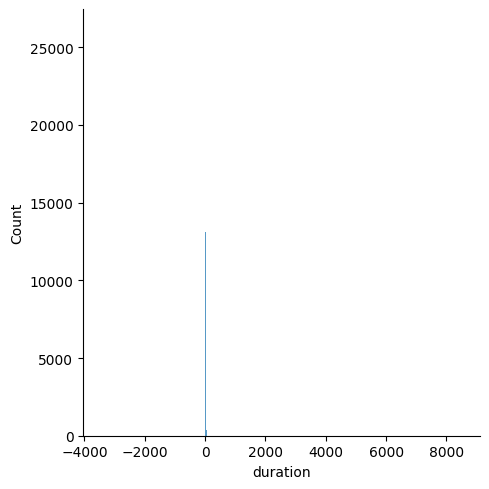

In [17]:
plt.figure(figsize=(10, 5))
sns.displot(jan_df["duration"])

In [18]:
# lets remove the values below 1

df_after_outlier_removed = jan_df.loc[(jan_df["duration"] >= 1) & (jan_df["duration"] <= 60)]

In [19]:
df_after_outlier_removed ["duration"].describe()

count    2.421440e+06
mean     1.267128e+01
std      8.999282e+00
min      1.000000e+00
25%      6.433333e+00
50%      1.023333e+01
75%      1.613333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [20]:
q1 = df_after_outlier_removed["duration"].quantile(0.25)
q3 = df_after_outlier_removed ["duration"].quantile(0.75)
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

display(f"low : {low} , high : {high}")

'low : -8.341666666666669 , high : 30.908333333333335'

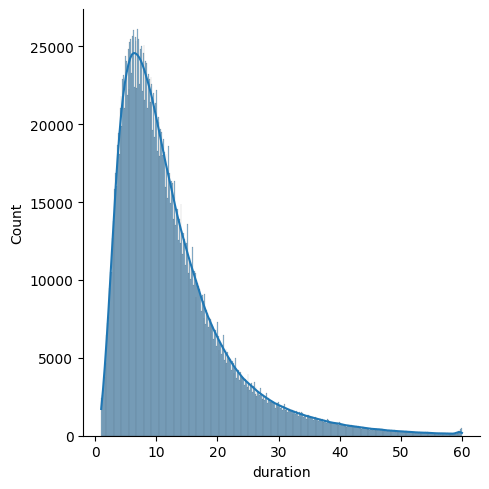

In [21]:
sns.displot(df_after_outlier_removed ["duration"], kde=True)

In [22]:
display(f"Fraction of the records left after dropping the outliers: {len(df_after_outlier_removed )/len(jan_df)}")

'Fraction of the records left after dropping the outliers: 0.9827547930522406'

In [23]:
df_after_outlier_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421440 entries, 0 to 2463930
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [24]:
df_after_outlier_removed['PULocationID']  = df_after_outlier_removed['PULocationID'].astype('str')
df_after_outlier_removed['DOLocationID']  = df_after_outlier_removed['DOLocationID'].astype('str')

In [25]:
df_after_outlier_removed['PU_DO'] =df_after_outlier_removed['PULocationID'] + '_' + df_after_outlier_removed['DOLocationID']

In [26]:
df_after_outlier_removed['PU_DO'].nunique()

20666

In [27]:
df_after_outlier_removed['duration'].nunique()

3541

In [28]:
jan_df['duration'].nunique()

8184

In [29]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [30]:



dv = DictVectorizer()

train_dicts = df_after_outlier_removed[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train =df_after_outlier_removed[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

display(X_train.shape)
y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

4.7972556342229815

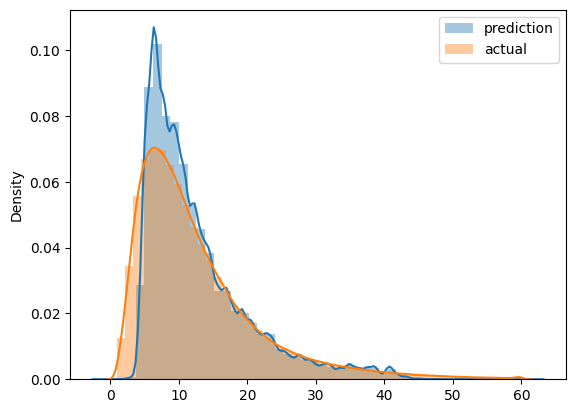

In [31]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [32]:
feb_df = pd.read_parquet(os.path.join(DATASET_PATH, "yellow_tripdata_2022-02.parquet"))

In [33]:
feb_df["duration"] = feb_df["tpep_dropoff_datetime"] - feb_df["tpep_pickup_datetime"]

feb_df["duration"] = feb_df["duration"].dt.total_seconds()/60

feb_df['PULocationID']  = feb_df['PULocationID'].astype('str')
feb_df['DOLocationID']  = feb_df['DOLocationID'].astype('str')

feb_df['PU_DO'] =feb_df['PULocationID'] + '_' + feb_df['DOLocationID']

df_val = feb_df.loc[(feb_df["duration"] >= 1) & (feb_df["duration"] <= 60)]

test_dicts = df_val[categorical + numerical].to_dict(orient='records')

X_test = dv.transform(test_dicts)
display(X_test.shape)

y_test = df_val[target].values

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

5.5302866921268

In [34]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

: 

: 